In [1]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import tie.utils as qa
import pandas as pd
from scipy.io import savemat, loadmat
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import DivergingNorm, TwoSlopeNorm, Normalize
from statsmodels.stats.multitest import fdrcorrection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from sklearn.neighbors import KernelDensity

In [2]:
rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)

ORDER = [0, 2, 3, 1] # Full, Social, Transition, Launcher
version = 'v6_IRLS'

In [3]:
study_id_1 = 'aef31aeb7b4d9dde43779738b42be454dc0ede19'  # -- Leiden Uni Age Study
study_id_2 = "aef333cc3597c660421091c3f4d8ecb4e809de19" # -- Leiden Uni 
study_id_3 = "aef34cc4d24c162f4f87becb74515e392560de19" # -- COOLS

In [4]:
raw_query = '''SELECT SDV."partId", SDV."devicePartId" as "devPartId", tde."deviceInfo", tde."id", "modified", "created"
from "StudyDetailsView" SDV
JOIN "TapDevice" tde on SDV."tapDeviceId" = tde."id"
where SDV."studyId"=? or SDV."studyId"=? or SDV."studyId"=?;'''
df = db.raw_query(raw_query, params=[study_id_1, study_id_2, study_id_3])
df['days'] = (df['modified'] - df['created'] ) / 1000 / 3600 / 24
df.head(2)

,partId,devPartId,deviceInfo,id,modified,created,days
0,138efc8063d3729040fb817663edae7c94b328eb,8sd8fe9d359d9d654c7fafb8efc55def56dc12ka,"{""androidVersion"":""9"",""deviceManufacturer"":""On...",0032fe57-d169-4a43-919d-bd415de40a8e,1592896678076,1587754338923,59.517814
1,138ee12eb779c05544cba2bfee03ecef1feb28eb,8sd8a4534d5635cb4936a9d848e019dfa68f12ka,"{""androidVersion"":""9"",""deviceManufacturer"":""mo...",00431dfe-0245-47fe-879e-e641daa55dc9,1568805227286,1565089811972,43.002492


In [5]:
info_age = pd.read_csv('../../../only_info_figure_1.csv')
full_info = info_age.merge(df, on='partId').dropna().drop_duplicates("partId")
full_info.head(2)

,partId,age,n_taps,gender,devPartId,deviceInfo,id,modified,created,days
0,138ee6d165fa06954ba1bed56719415b12dd28eb,60,2645834,2,8sd8474d8c7c03ef46c5b3acf034d689257c12ka,"{""androidVersion"":""11"",""deviceManufacturer"":""s...",9feae480-d169-486e-b00d-02fcf4585d44,1626185826959,1593108388846,382.840719
2,138ee5b320ea6ee948d2a3bf2f8c55ffecd428eb,23,339201,2,8sd8762e35b65efa465fb90c7d2b7f5b5ad012ka,"{""androidVersion"":""10"",""deviceManufacturer"":""s...",f23fd700-1d72-4db0-a584-e7f979ad6d92,1620035028533,1593642422788,305.469974


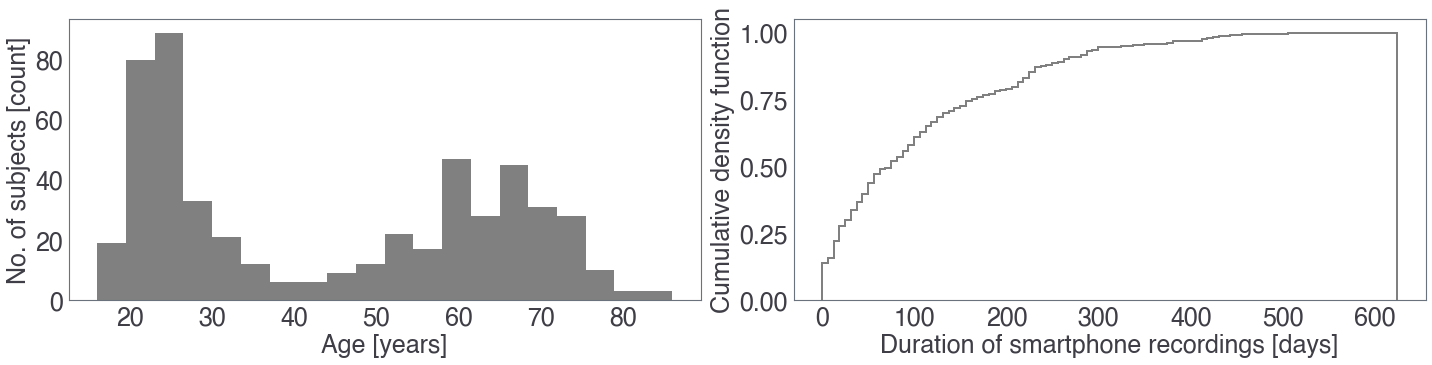

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

## AGE
full_info["age"].hist(bins=20, ax=ax[0], color='grey')

ax[0].set_xlabel("Age [years]")
ax[0].set_ylabel("No. of subjects [count]")
ax[0].grid(False)

## DAYS
n, bins, _ = ax[1].hist(full_info["days"], 100, density=True, histtype='step',
                           cumulative=True, color='grey', alpha=1.0, linewidth=2)
# ax[1].step(np.cumsum(sorted(full_info["days"])[::-1]), np.cumsum(sorted(full_info["days"])[::-1]) / full_info["days"].sum(), color='grey')
# full_info["days"].hist(bins=20, ax=ax[1], color='grey')

ax[1].set_xlabel("Duration of smartphone recordings [days]")
ax[1].set_ylabel("Cumulative density function")
ax[1].grid(False)

plt.tight_layout()
plt.savefig('figure_1_panel_a.pdf', transparent=True)

In [7]:
df_fig1pana = pd.DataFrame(columns={'type', 'N', 'min', 'max', '25th', '50th', '75th'})
df_fig1pana['type'] = ['female', 'age', 'days']
df_fig1pana['N'] = [len(full_info[full_info['gender'] == 2]), len(full_info), len(full_info)]
df_fig1pana['min'] = [np.nan, min(full_info['age']), min(full_info['days'])]
df_fig1pana['max'] = [np.nan, max(full_info['age']), max(full_info['days'])]
df_fig1pana['25th'] = [np.nan, np.percentile(full_info['age'], 25), np.percentile(full_info['days'], 25)]
df_fig1pana['50th'] = [np.nan, np.percentile(full_info['age'], 50), np.percentile(full_info['days'], 50)]
df_fig1pana['75th'] = [np.nan, np.percentile(full_info['age'], 75), np.percentile(full_info['days'], 75)]
df_fig1pana.to_csv('figure_1_panel_a.csv', index=False)
df_fig1pana

,50th,max,75th,type,25th,min,N
0,NaN,NaN,NaN,female,NaN,NaN,319
1,41.000000,86.000000,63.0000,age,23.000000,16.0,521
2,75.966403,623.510652,166.0847,days,20.105228,0.0,521


# Panel b

<ipython-input-8-c6b09184e234>:27: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


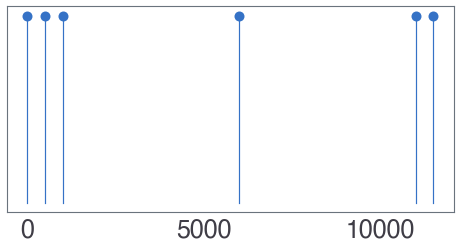

In [8]:
eps = 1e-5
BINS = 50
MIN_H = 1.5
MAX_H = 5
xx, yy = np.mgrid[MIN_H : MAX_H : BINS * 1j, MIN_H : MAX_H : BINS * 1j]
xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T

t = np.array([0, 0.5, 1, 6, 11, 11.5]) * 1000
dt = np.diff(t)

log_dt1, log_dt2 = np.log10(dt[:-1] + eps), np.log10(dt[1:] + eps)
xy_train  = np.vstack([log_dt1, log_dt2]).T
kde_skl = KernelDensity(bandwidth=0.1)
kde_skl.fit(xy_train)
z = np.exp(kde_skl.score_samples(xy_sample))
dt_dt = np.reshape(z, xx.shape)
fig = plt.figure(constrained_layout=True, figsize=(6.5, 10))
gs = fig.add_gridspec(3, 1)
ax = fig.add_subplot(gs[0, :])

ax.plot(t, np.ones_like(t), 'o', markersize=10)
ax.plot(np.concatenate([t[:, None], t[:, None]], 1).T, np.concatenate([np.array([0, 1])[:, None] for _ in range(len(t))], 1), 'b')
ax.grid(False)
ax.get_yaxis().set_visible(False)


plt.tight_layout()
plt.savefig('figure_1_panel_b_sub1.pdf')

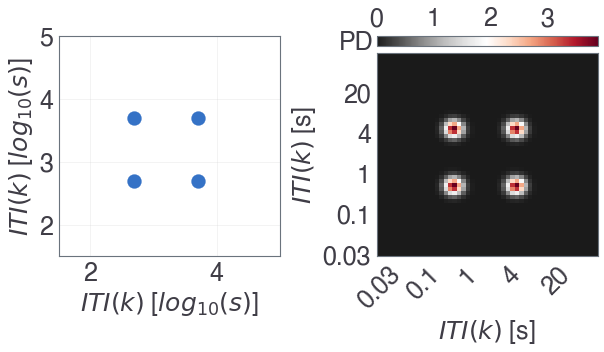

In [62]:
eps = 1e-5
BINS = 50
MIN_H = 1.5
MAX_H = 5
labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]
xx, yy = np.mgrid[MIN_H : MAX_H : BINS * 1j, MIN_H : MAX_H : BINS * 1j]
xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T

t = np.array([0, 0.5, 1, 6, 11, 11.5]) * 1000
dt = np.diff(t)

log_dt1, log_dt2 = np.log10(dt[:-1] + eps), np.log10(dt[1:] + eps)
xy_train  = np.vstack([log_dt1, log_dt2]).T
kde_skl = KernelDensity(bandwidth=0.1)
kde_skl.fit(xy_train)
z = np.exp(kde_skl.score_samples(xy_sample))
dt_dt = np.reshape(z, xx.shape)
fig, ax = plt.subplots(1, 2, figsize=(8.5, 5))

ax[0].scatter(log_dt1, log_dt2, s=200)
ax[0].set_xlim([1.5, 5])
ax[0].set_ylim([1.5, 5])
ax[0].set_ylabel(r'$ITI(k)$ [$log_{10}(s)$]')
ax[0].set_xlabel(r'$ITI(k)$ [$log_{10}(s)$]')
ax[0].grid(True, alpha=0.5, linewidth=0.5)

im = ax[1].imshow(dt_dt, aspect='auto', cmap='RdGy_r')
ax[1].invert_yaxis()
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(labels)
ax[1].xaxis.set_tick_params(rotation=45)
ax[1].set_yticks(ticks)
ax[1].set_yticklabels(labels)
ax[1].set_ylabel(r'$ITI(k)$ [s]')
ax[1].set_xlabel(r'$ITI(k)$ [s]')
ax[1].text(-9, 50.5, 'PD', size=25)


ax[1].grid(False)
divider = make_axes_locatable(ax[1])
cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
fig.add_axes(cax)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position('top')

plt.tight_layout()
plt.savefig('figure_1_panel_b_sub2.pdf')

# Panel c

In [11]:
allJIDs = loadmat('ex_all_jids.mat')

In [12]:
fullJID = allJIDs['fullJID']
socialJID = allJIDs['socialJID']
transitionJID = allJIDs['transitionJID']
print(fullJID.shape)

(50, 50)


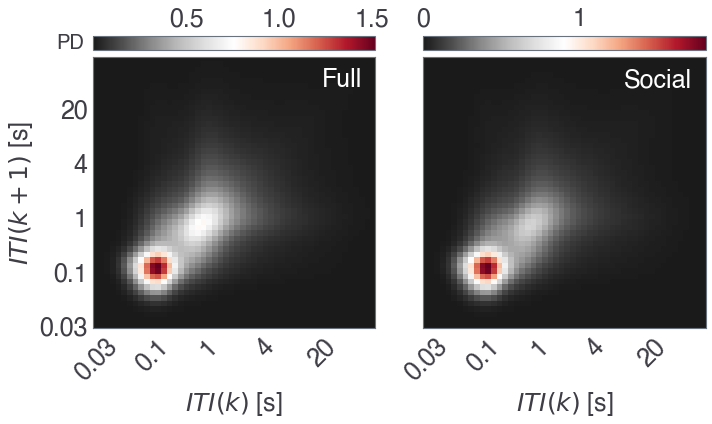

In [56]:
# This is over 166 days
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for i, (_JID, _title, x_bias) in enumerate(zip([fullJID, socialJID], 
                             ['Full', 'Social'],
                             [40, 35])):
    im = ax[i].imshow(_JID.T, aspect='auto', cmap='RdGy_r')
    ax[i].text(x_bias, 44, f"{_title}", fontsize=25, color='white')
    ax[i].invert_yaxis()
    ax[i].set_xticks(ticks)
    ax[i].set_xticklabels(labels)
    ax[i].xaxis.set_tick_params(rotation=45)
    ax[i].set_yticks(ticks)
    ax[i].set_yticklabels(labels)
    ax[i].grid(False)
    divider = make_axes_locatable(ax[i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
ax[1].set_xlabel(r'$ITI(k)$ [s]')
ax[0].set_xlabel(r'$ITI(k)$ [s]')
ax[0].set_ylabel(r'$ITI(k + 1)$ [s]');
# ax[1].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0].text(-7, 51, 'PD', size=20)
# ax[1].text(-7, 51, 'PD', size=20)
plt.tight_layout()
plt.savefig('figure_1_panel_c.pdf', transparent=True)

# Panel d

In [14]:
version = 'v6_IRLS'
all_age_res = loadmat(f'../../../all_age_gender_log_{version}.mat')['all_age_gender'][0]  # 4 structs for 4 JIDs
data_it = all_age_res[0].flat[0][0].flat[0]
Afull = data_it[3].squeeze().reshape(-1, 50, 50).T
data_it = all_age_res[2].flat[0][0].flat[0]
Asocial = data_it[3].squeeze().reshape(-1, 50, 50).T
print(Afull.shape)
print(Asocial.shape)

(50, 50, 515)
(50, 50, 499)


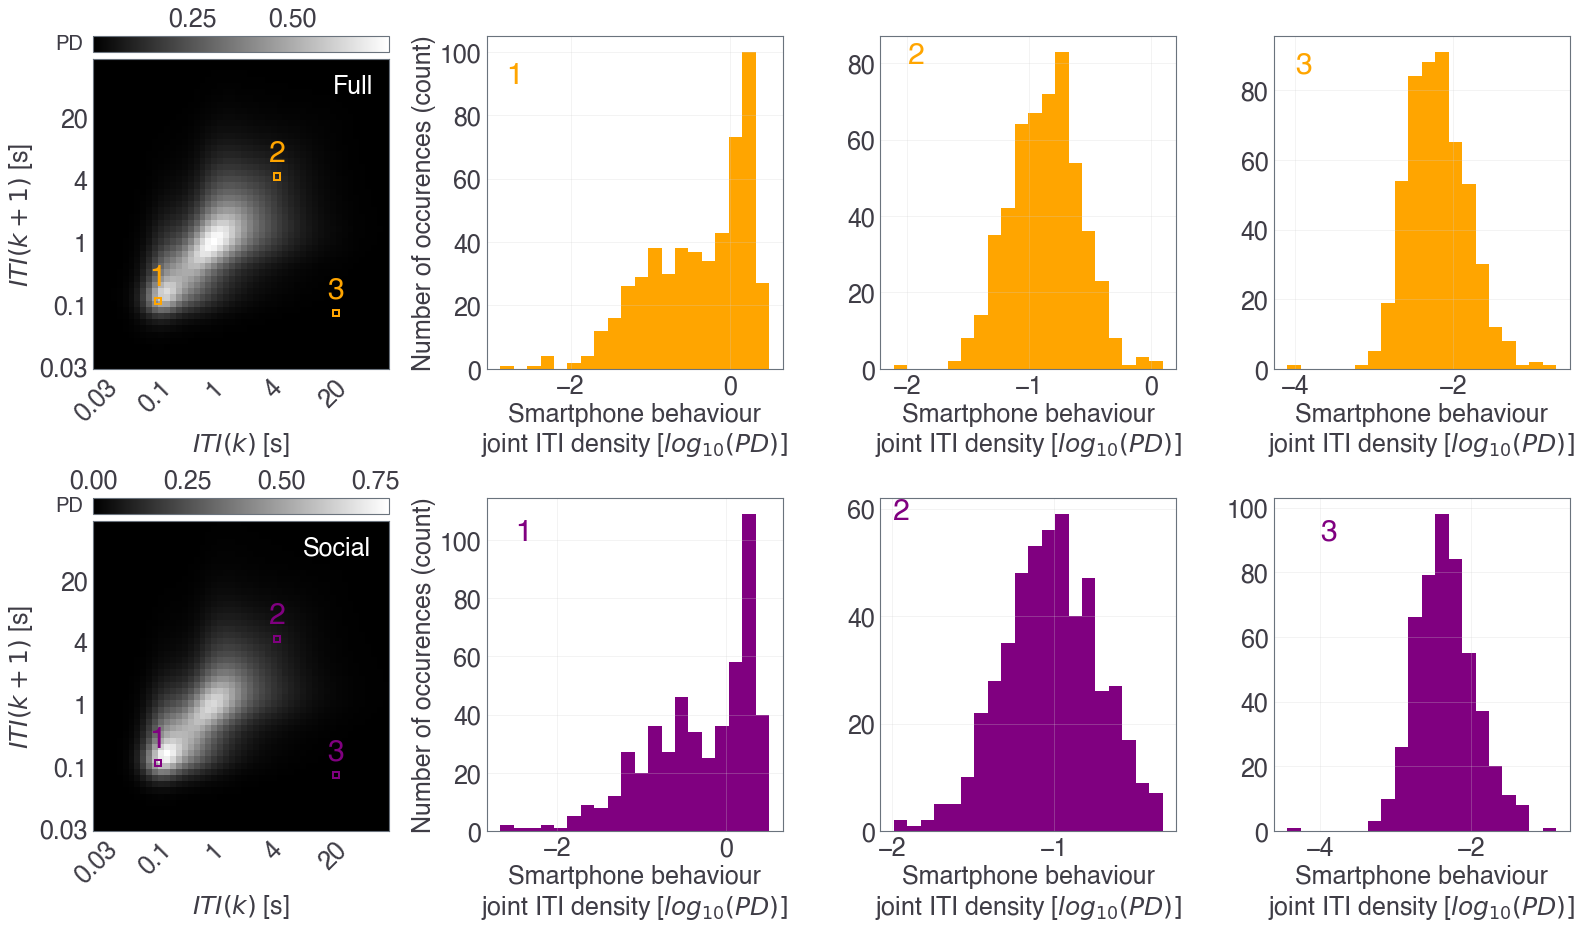

In [51]:
# This is over 166 days
fig, ax = plt.subplots(2, 4, figsize=(22, 13))

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for i, (_JID, _title, x_bias, pixel, col, text_coo) in enumerate(zip([Afull, Asocial], 
                             ['Full', 'Social'],
                             [40, 35], [10, 20], 
                             ['orange', 'purple'], 
                             [[(-2.8, 90), (-2, 80), (-4, 85)], [(-2.5, 100), (-2, 58), (-4, 90)]])):
    im = ax[i][0].imshow(10 ** _JID.mean(-1).T, aspect='auto', cmap='gray')
    ax[i][0].text(x_bias, 44, f"{_title}", fontsize=25, color='white')
    ax[i][0].invert_yaxis()
    ax[i][0].set_xticks(ticks)
    ax[i][0].set_xticklabels(labels)
    ax[i][0].xaxis.set_tick_params(rotation=45)
    ax[i][0].set_yticks(ticks)
    ax[i][0].set_yticklabels(labels)
    ax[i][0].set_xlabel(r'$ITI(k)$ [s]')
    ax[i][0].grid(False)
    divider = make_axes_locatable(ax[i][0])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    
    p1 = (10, 10)
    p2 = (30, 30)
    p3 = (40, 8)
    
    ax[i][1].hist(_JID[p1[0], p1[0]], bins=20, color=col)
    rect = patches.Rectangle(p1, 1, 1, linewidth=2, edgecolor=col, facecolor='none')
    ax[i][0].add_patch(rect)
    ax[i][1].grid(True, alpha=0.5, linewidth=0.5)
    ax[i][1].text(text_coo[0][0], text_coo[0][1], f"1", fontsize=30, color=col)
    ax[i][0].text(p1[0] - 1, p1[1] + 3, f"1", fontsize=30, color=col)
    ax[i][1].set_xlabel('Smartphone behaviour\n' + r'joint ITI density [$log_{10}(PD)]$')
    
    ax[i][2].hist(_JID[p2[0], p2[0]], bins=20, color=col)
    rect = patches.Rectangle(p2, 1, 1, linewidth=2, edgecolor=col, facecolor='none')
    ax[i][0].add_patch(rect)
    ax[i][2].grid(True, alpha=0.5, linewidth=0.5)
    ax[i][2].text(text_coo[1][0], text_coo[1][1], f"2", fontsize=30, color=col)
    ax[i][0].text(p2[0] - 1, p2[1] + 3, f"2", fontsize=30, color=col)
    ax[i][2].set_xlabel('Smartphone behaviour\n' + r'joint ITI density [$log_{10}(PD)]$')
    
    ax[i][3].hist(_JID[p3[0], p3[0]], bins=20, color=col)
    rect = patches.Rectangle(p3, 1, 1, linewidth=2, edgecolor=col, facecolor='none')
    ax[i][0].add_patch(rect)
    ax[i][3].grid(True, alpha=0.5, linewidth=0.5)
    ax[i][3].text(text_coo[2][0], text_coo[2][1], f"3", fontsize=30, color=col)
    ax[i][0].text(p3[0] - 1, p3[1] + 3, f"3", fontsize=30, color=col)
    ax[i][3].set_xlabel('Smartphone behaviour\n' + r'joint ITI density [$log_{10}(PD)]$')
    
ax[0][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[1][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0][0].text(-7, 51, 'PD', size=20)
ax[1][0].text(-7, 51, 'PD', size=20)
ax[1][1].set_ylabel('Number of occurences (count)')
ax[0][1].set_ylabel('Number of occurences (count)')


plt.tight_layout()
plt.savefig('figure_1_panel_d.pdf', transparent=True)

# Supplementary b.i.

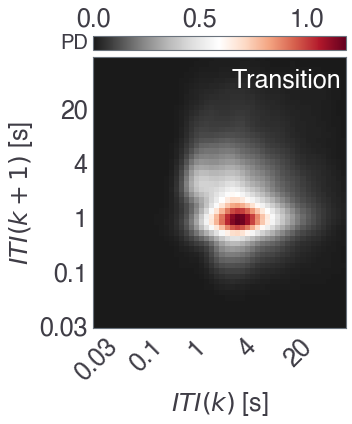

In [16]:
# This is over 166 days
fig, ax = plt.subplots(1, 1, figsize=(5, 6), sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for i, (_JID, _title, x_bias) in enumerate(zip([transitionJID], 
                             ['Transition'],
                             [27])):
    im = ax.imshow(_JID.T, aspect='auto', cmap='RdGy_r')
    ax.text(x_bias, 44, f"{_title}", fontsize=25, color='white')
    ax.invert_yaxis()
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    ax.set_xlabel(r'$ITI(k)$ [s]')
    ax.grid(False)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
ax.set_ylabel(r'$ITI(k + 1)$ [s]');
ax.text(-7, 51, 'PD', size=20)
plt.tight_layout()
plt.savefig('figure_supplementary_b_i.pdf', transparent=True)